# Forecasting Hourly Energy Consumption with XGBoost

The goal of this notebook is to identify how accurate XGBoost can be in settings with limited data. Specifically, this notebook will use a day's worth of energy consumption data to predict the next day's consumption.

## Setup

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.stattools import durbin_watson
import math
plt.style.use('fivethirtyeight')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pjme = pd.read_csv('data/PJME_hourly.csv', index_col=[0], parse_dates=[0])

### Basic EDA

In [4]:
pjme.head(5)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


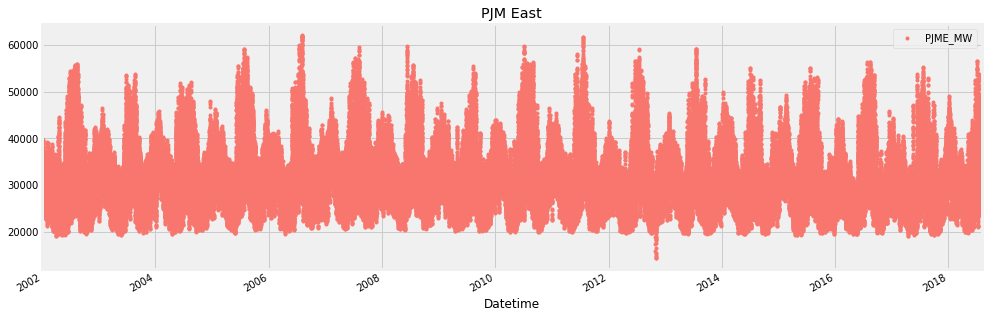

In [5]:
# Plotting timeseries
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
temp_plot = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

### Create Features

In [6]:
def create_lagged_features(df, lag_count):
    """Creates lagged features"""
    # lag_count should be the number of lags to create
    
    for i in range(0, lag_count):
        df['t-{}'.format(i+1)] = df['PJME_MW'].shift(i+1)

    return df

In [7]:
def create_features(df, lag_count, label=None):
    """Creates time series from a datetime index"""
    # Date Features
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    # Lagged Features
    
    df = create_lagged_features(df, lag_count)
    
    column_set = ['hour','dayofweek','quarter','month','year',
                   'dayofyear','dayofmonth','weekofyear']
    
    for i in range(0, lag_count):
        column_set.append('t-{}'.format(i+1))
    
    X = df[column_set]
    
    if label:
        y = df[label]
        # Drop first N (not enough lagged variables)
        X = X[lag_count:]
        y = y[lag_count:]
        return X, y
    
    # Drop first N (not enough lagged variables)
    X = X[lag_count:]
    
    return X

### Define Model

In [8]:
def create_model(X_train, y_train, X_test, y_test):
    start = datetime.datetime.now()
    reg = xgb.XGBRegressor(n_estimators=1000)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=50,
           verbose=False) # Change verbose to True if you want to see it train
    end = datetime.datetime.now()
    print("Total runtime for XGBoost: ", end-start)
    
    return reg

### Define MAPE Function

In [15]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Daily Train/Test Split and Prediction

### Plotting One Month of Predictions

In [37]:
def one_month_daily_predictions(year, pjme, lag_count):
    """
    Given a specific year, use each day(t) to predict energy usage on day(t+1).
    Note: Only makes predictions for days 2-28 of each month.
    Note: Because this function is plotting each day's resiuduals, this function will break after the first month.
    """
    
    dw_list = []
    rmse_list = []
    mape_list = []

    for month in range(1,13):
        # monthly loop
        for day in range(1,28):
            # day loop
            t_start = '{}-{}-{} 01:00:00'.format(year, month, day)
            t_end = '{}-{}-{} 23:00:00'.format(year, month, day)
            t_plus_one_start = '{}-{}-{} 01:00:00'.format(year, month, day+1)
            t_plus_one_end = '{}-{}-{} 23:00:00'.format(year, month, day+1)
            # get day(t) and day(t+1)
            day_t = pjme[t_start : t_end]
            day_t_plus_one = pjme[t_plus_one_start : t_plus_one_end]
            
            # plot
            temp_plot = day_t_plus_one \
                .rename(columns={'PJME_MW': 'TEST SET'}) \
                .join(day_t.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
                .plot(figsize=(15,5), title='PJM East', style='.')
            
            # create X and Y train and test sets
            X_train, y_train = create_features(day_t, lag_count, label='PJME_MW')
            X_test, y_test = create_features(day_t_plus_one, lag_count, label='PJME_MW')
            
            # create model
            reg = create_model(X_train, y_train, X_test, y_test)
            # apply lag to test
            day_t_plus_one = day_t_plus_one[lag_count:]
            # predict
            day_t_plus_one['MW_Prediction'] = reg.predict(X_test)
            # generate error
            day_t_plus_one['error'] = day_t_plus_one['MW_Prediction'] - day_t_plus_one['PJME_MW']
            
            # Plot the forecast against the actual observations
            f, ax = plt.subplots(1)
            f.set_figheight(5)
            f.set_figwidth(15)
            temp_plot = day_t_plus_one[['error']].plot(ax=ax,
                                                          style=['.'])
            ax.set_xbound(lower='{}-{}-{}'.format(year, month, day+1), upper='{}-{}-{}'.format(year, month, day+2))
            ax.set_ylim(-12000, 12000)
            plot = plt.suptitle('Error: Predicted minus Actual')
            
            rmse = math.sqrt(mean_squared_error(y_true=day_t_plus_one['PJME_MW'], y_pred=day_t_plus_one['MW_Prediction']))
            mape = round(mean_absolute_percentage_error(day_t_plus_one['PJME_MW'], day_t_plus_one['MW_Prediction']), 4)
            dw = durbin_watson(day_t_plus_one['error'])
            
            rmse_list.append(rmse)
            mape_list.append(mape)
            dw_list.append(dw)
            
        return rmse_list, mape_list, dw_list
            
        break

[09:36:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.058577
[09:36:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.010100
[09:36:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.012143
[09:36:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.031242
[09:36:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total ru

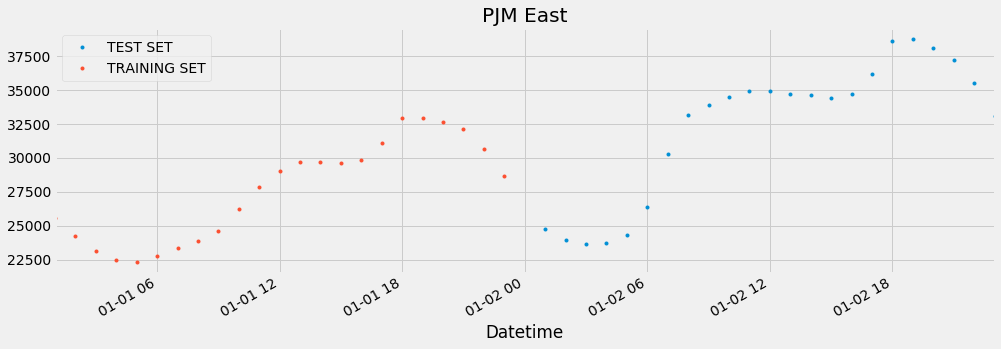

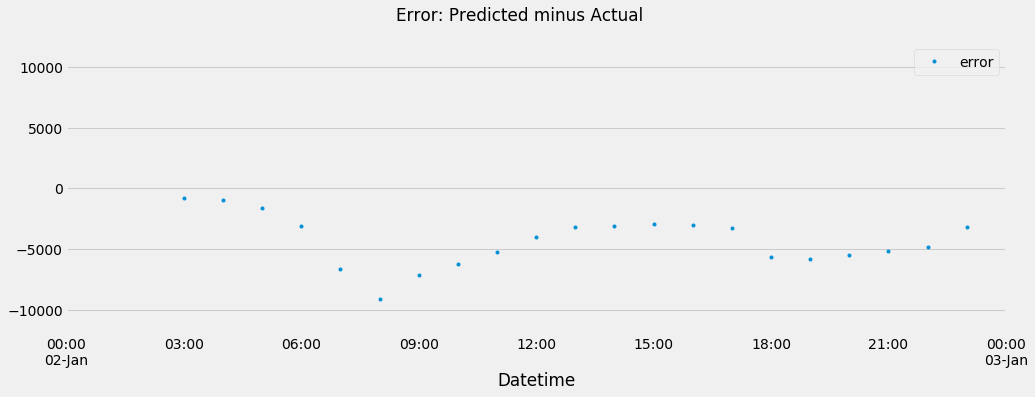

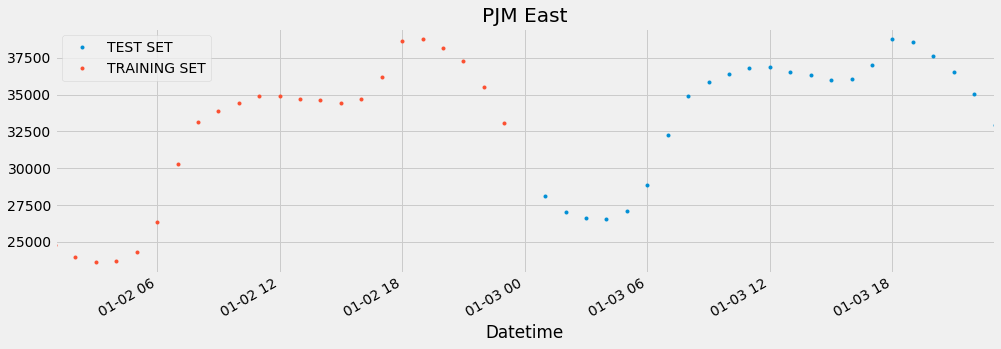

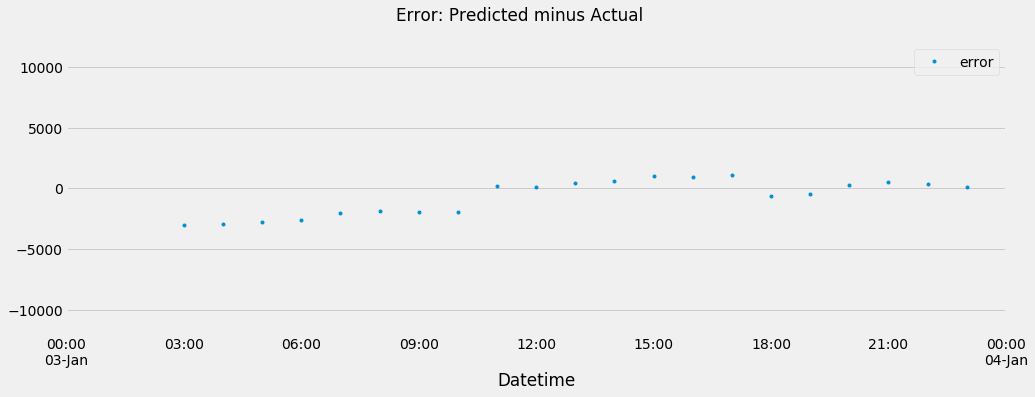

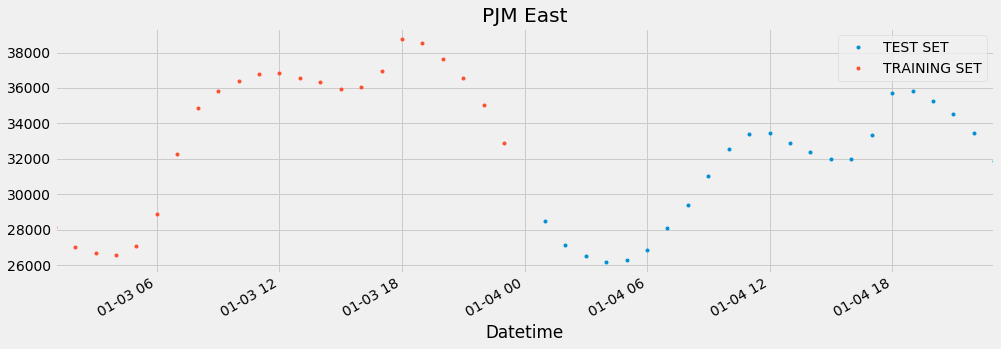

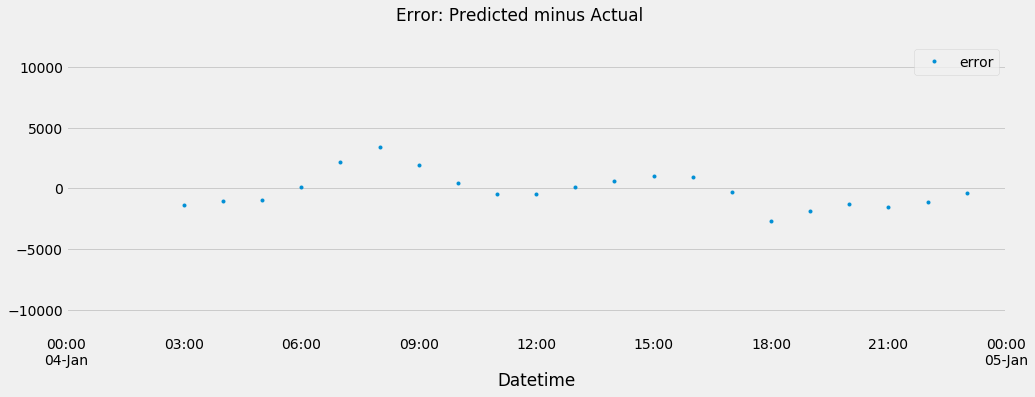

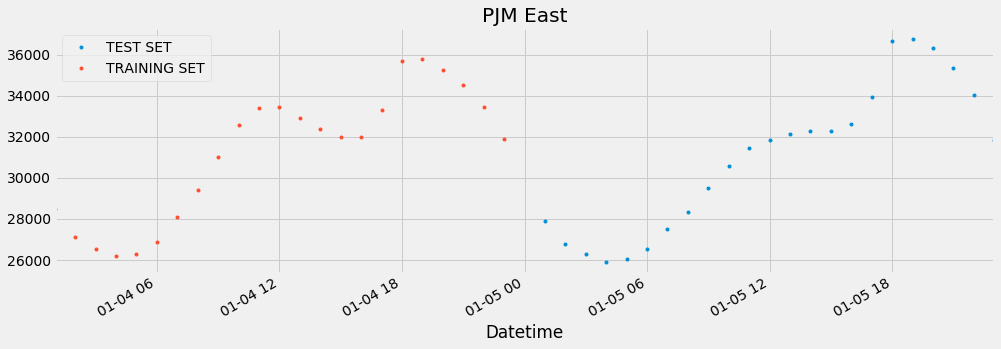

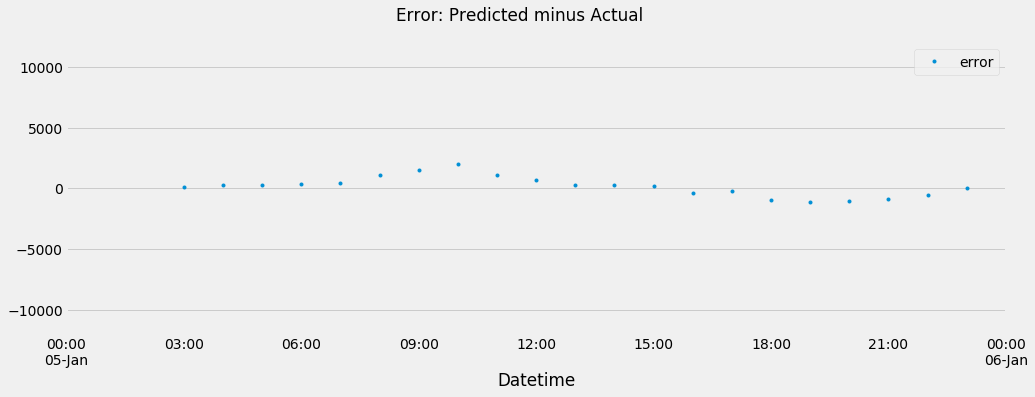

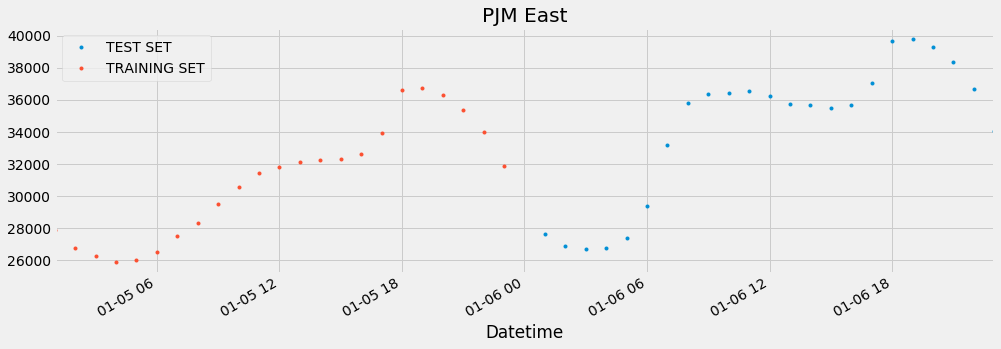

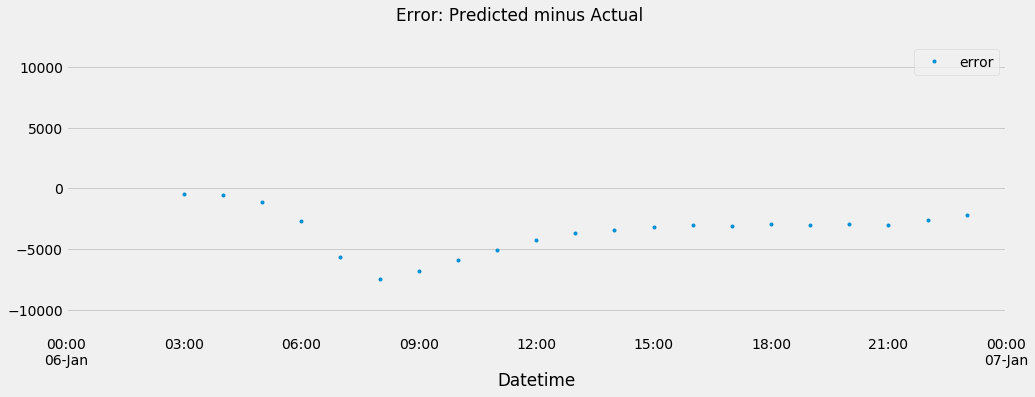

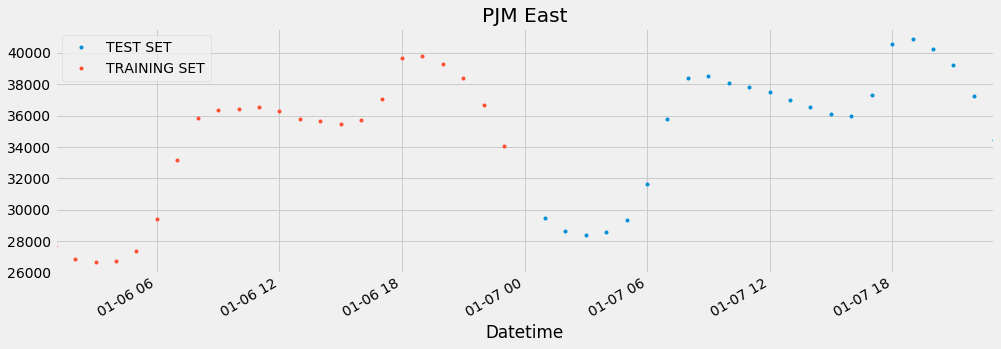

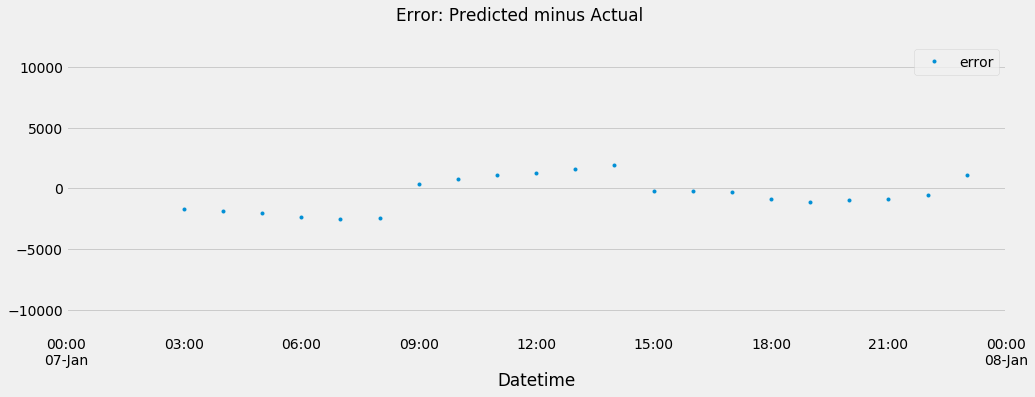

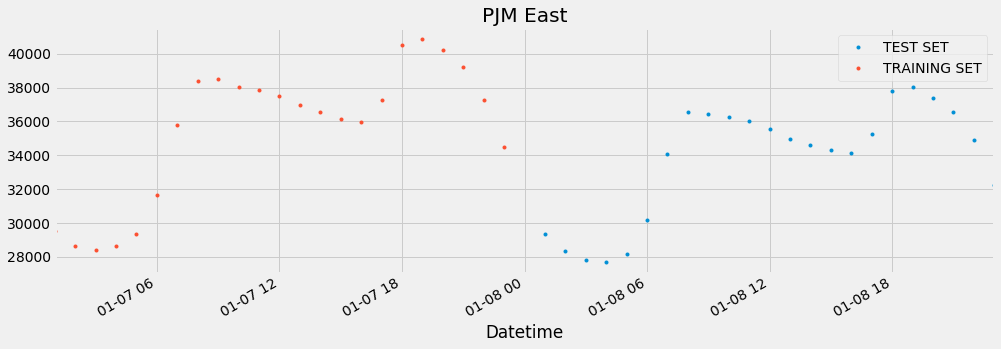

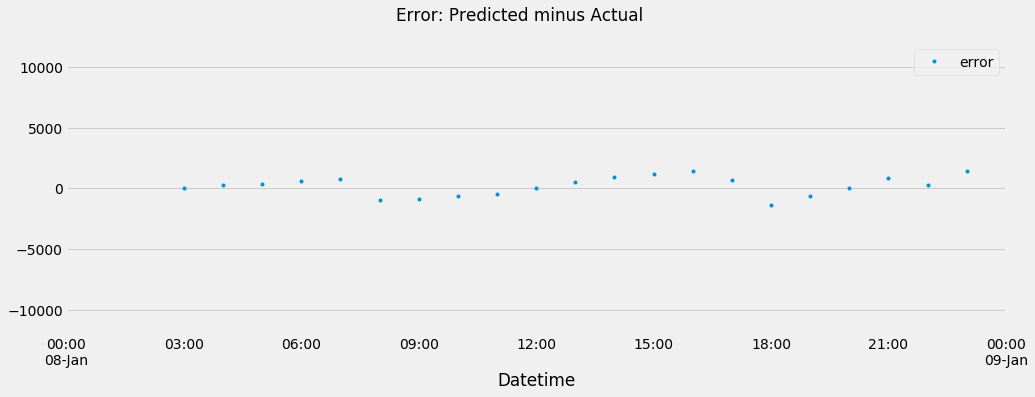

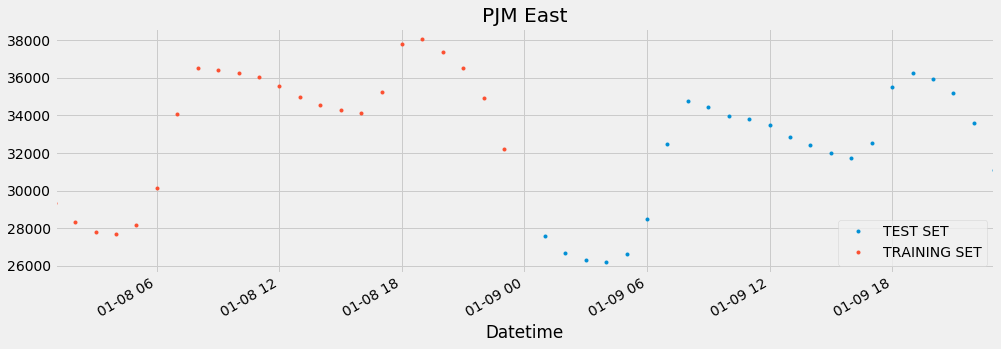

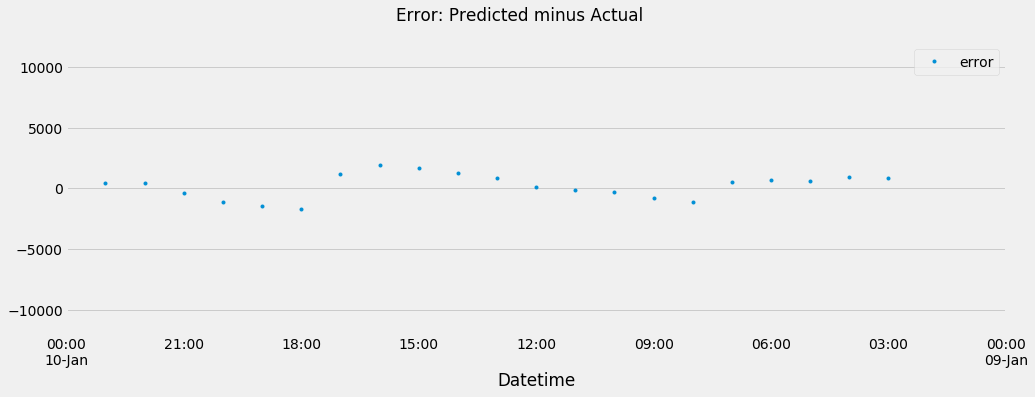

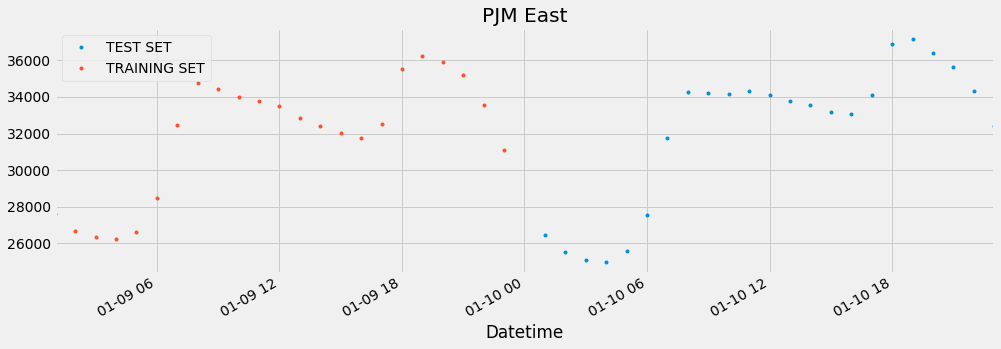

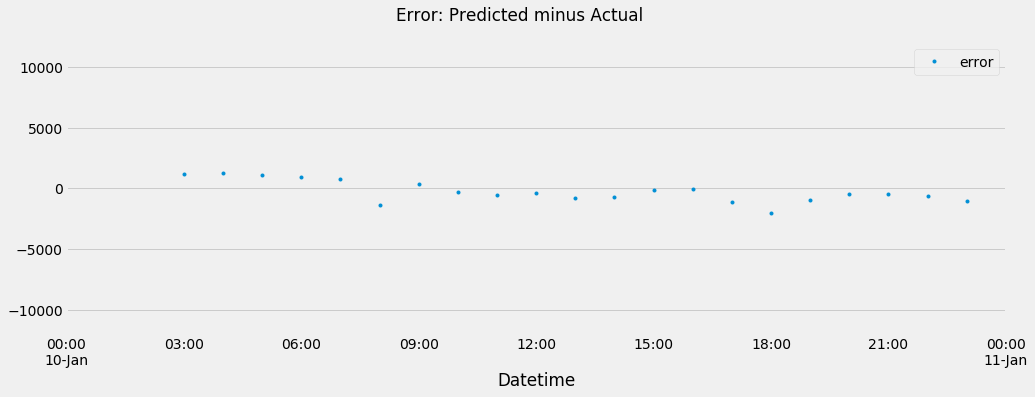

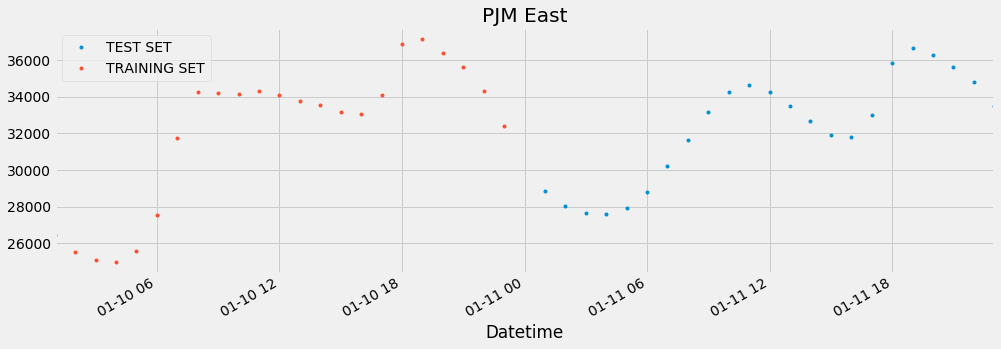

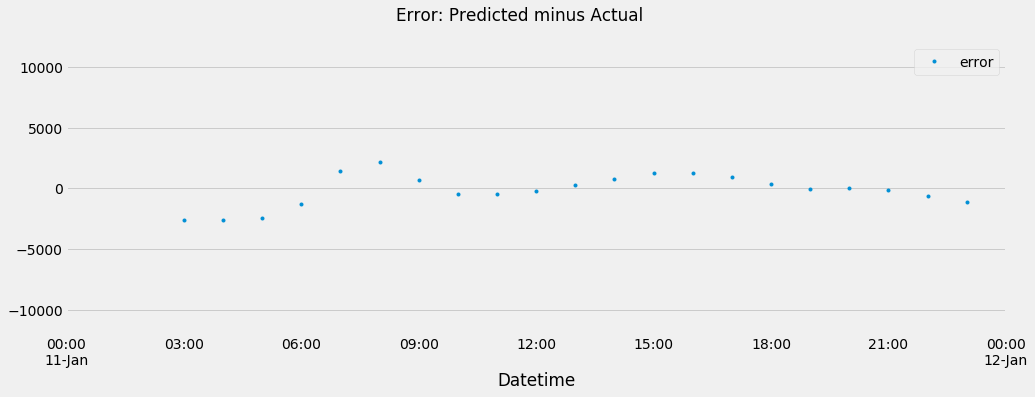

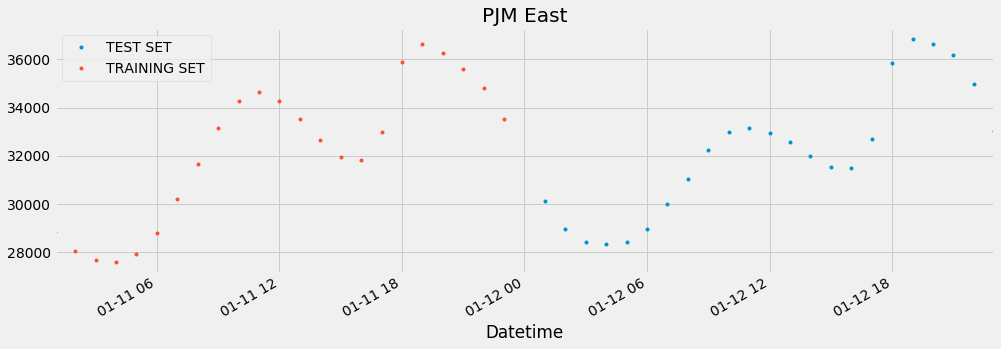

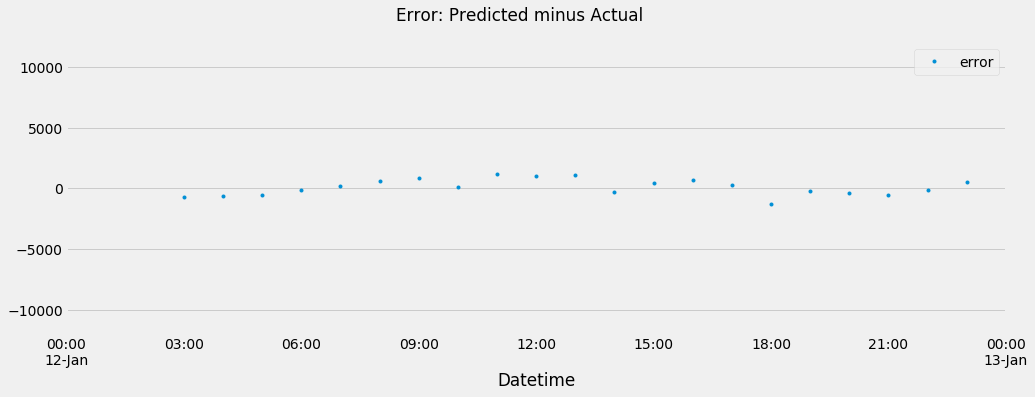

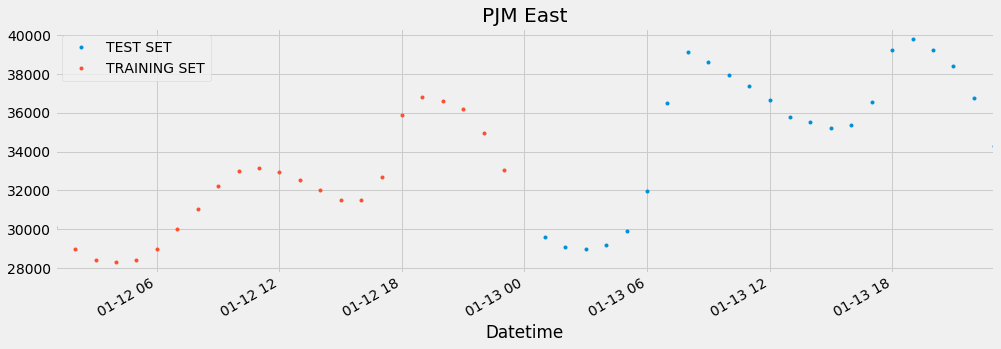

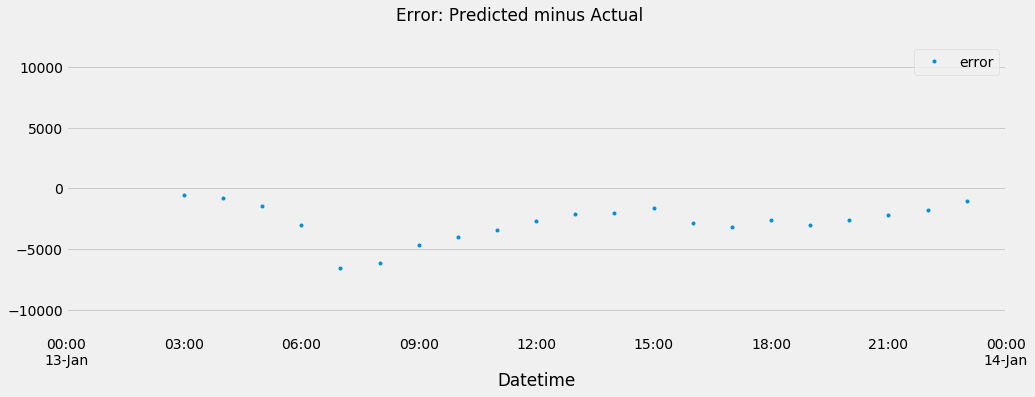

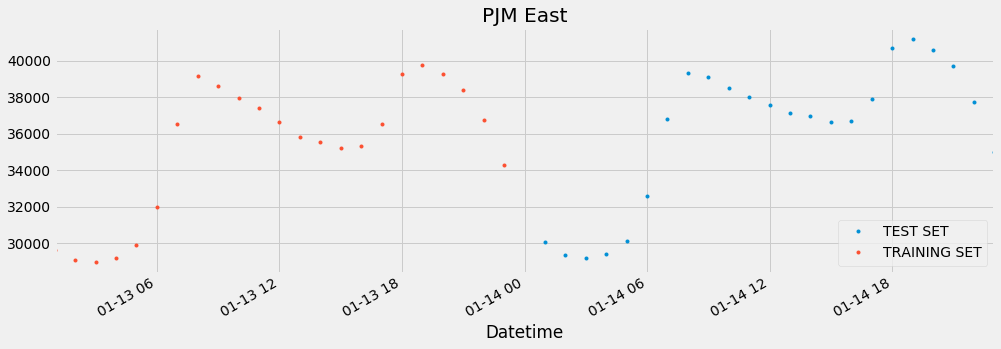

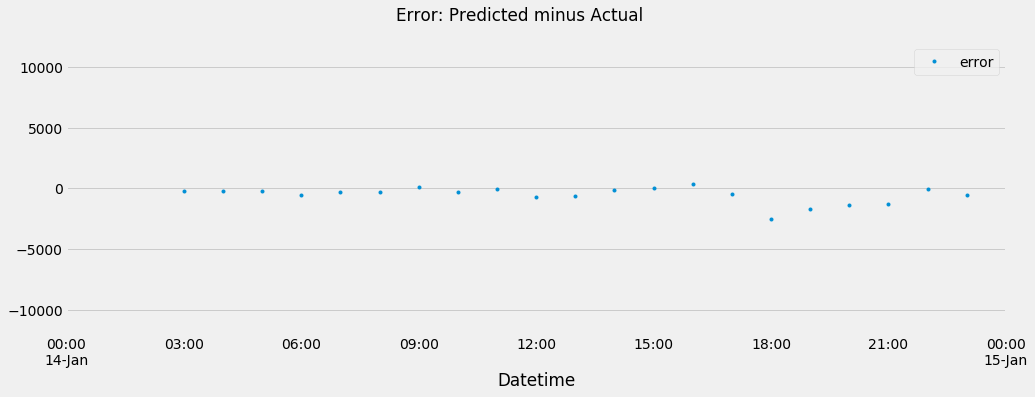

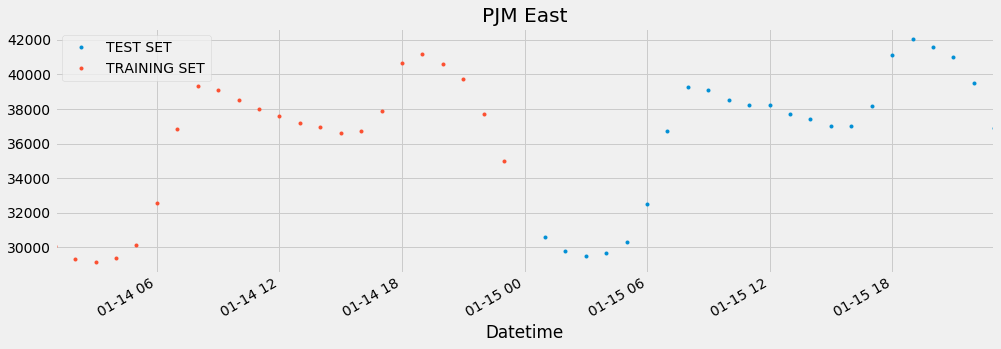

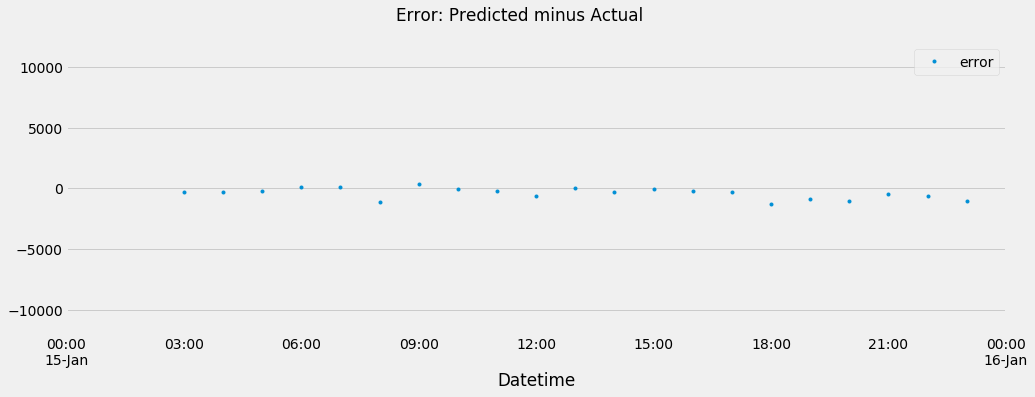

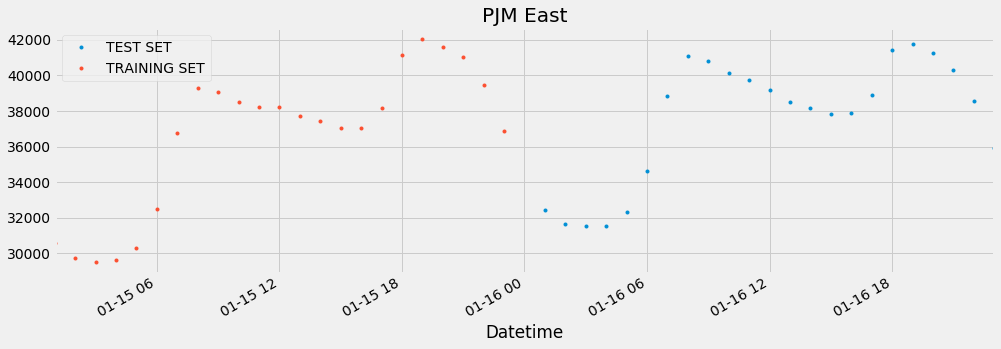

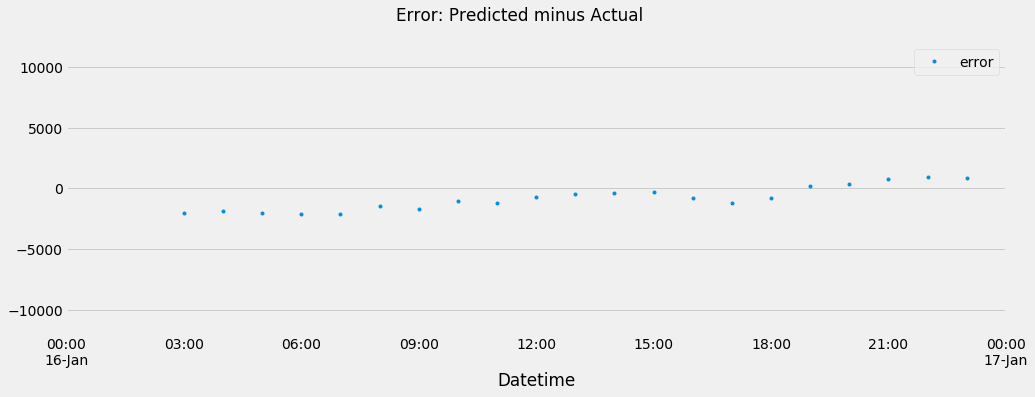

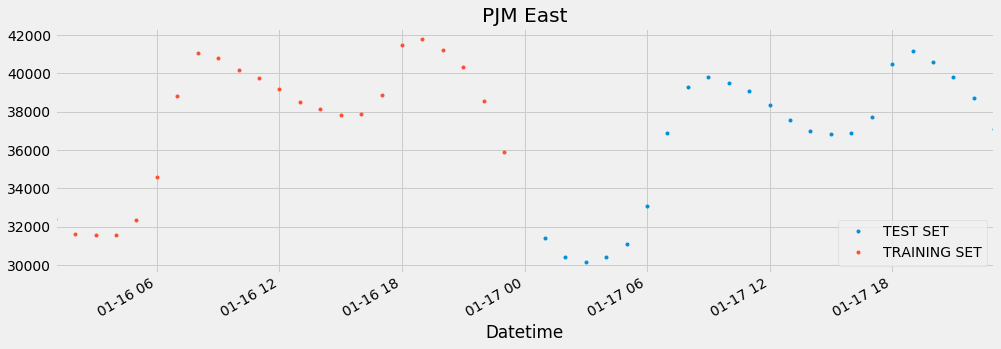

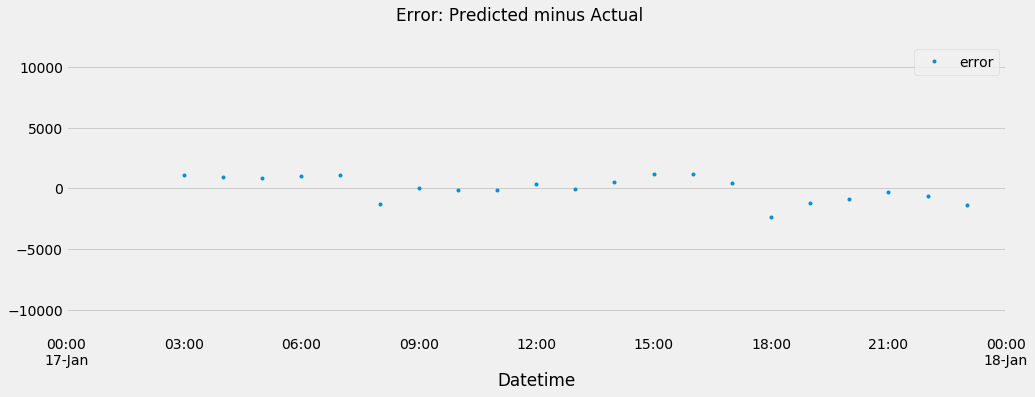

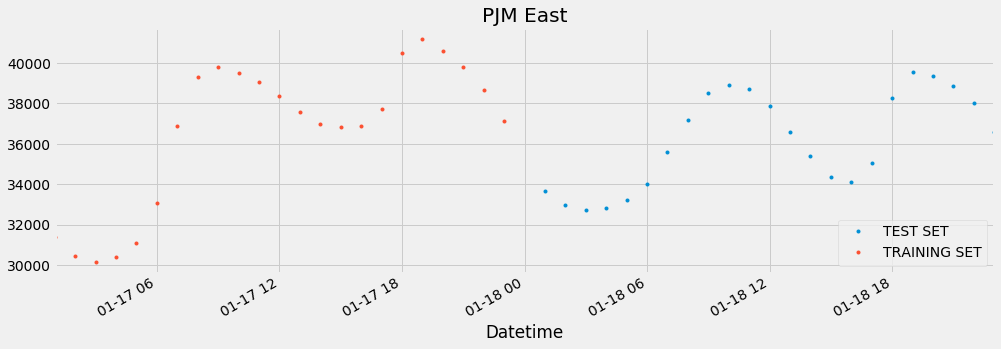

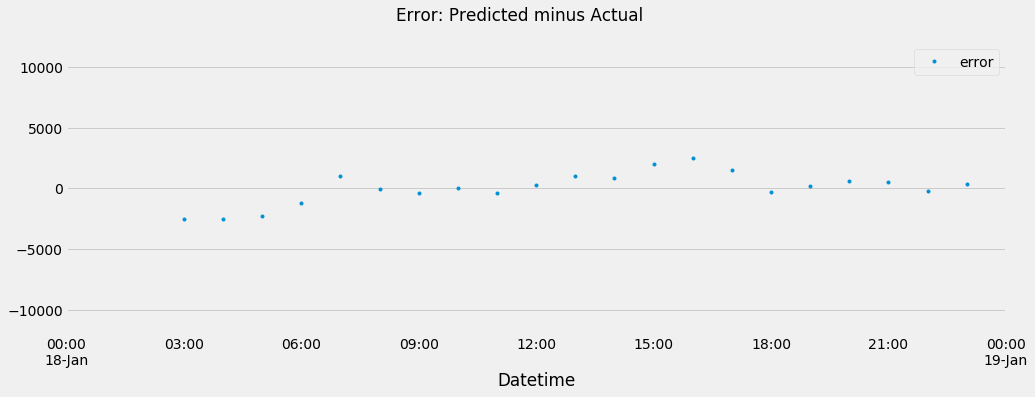

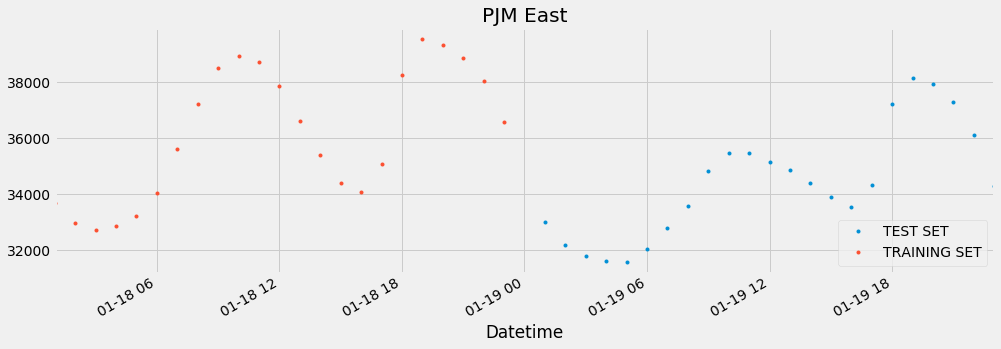

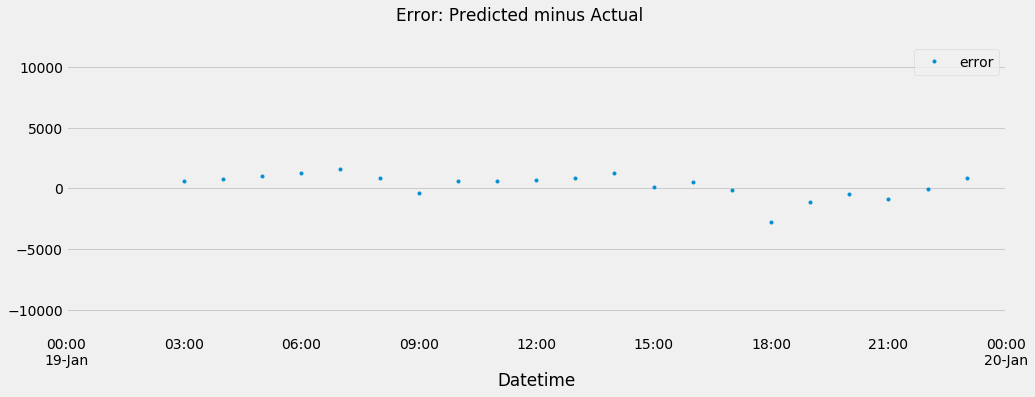

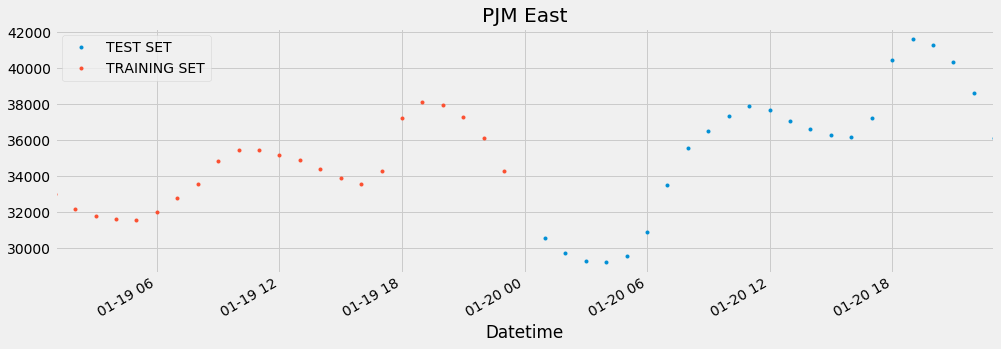

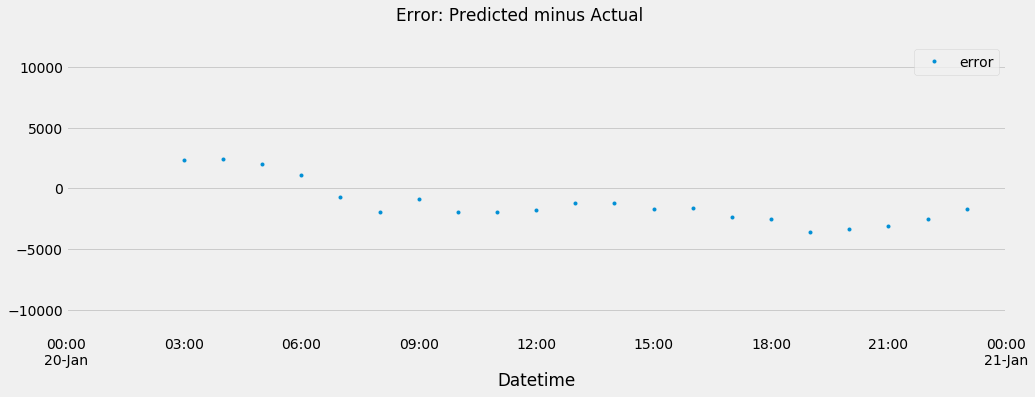

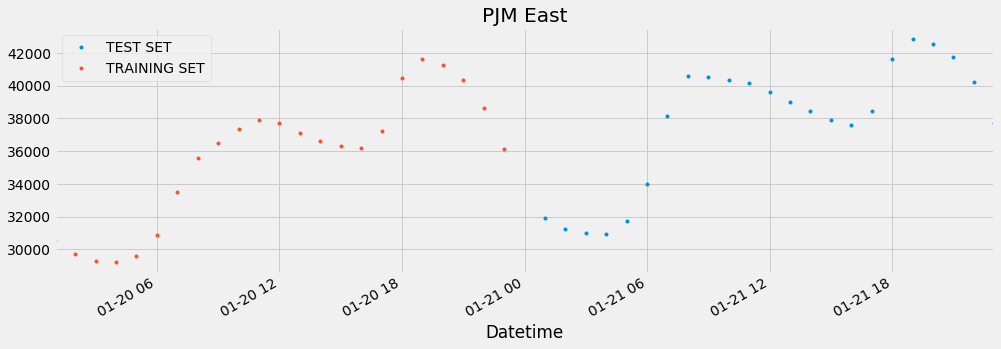

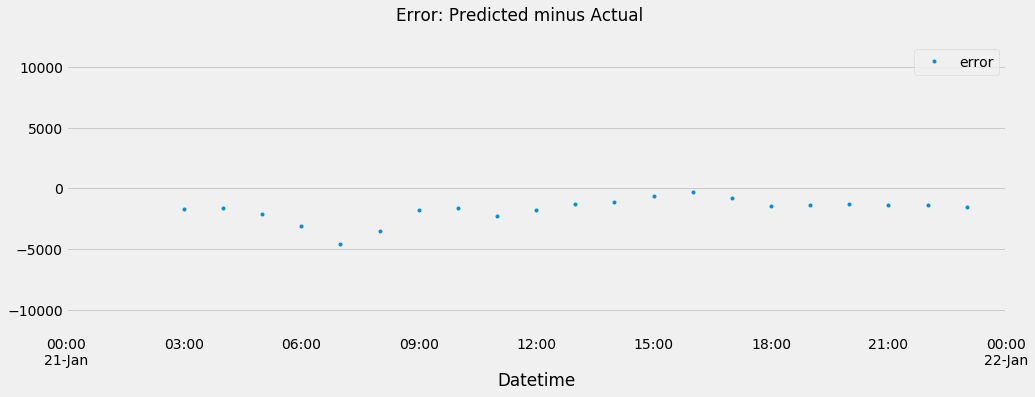

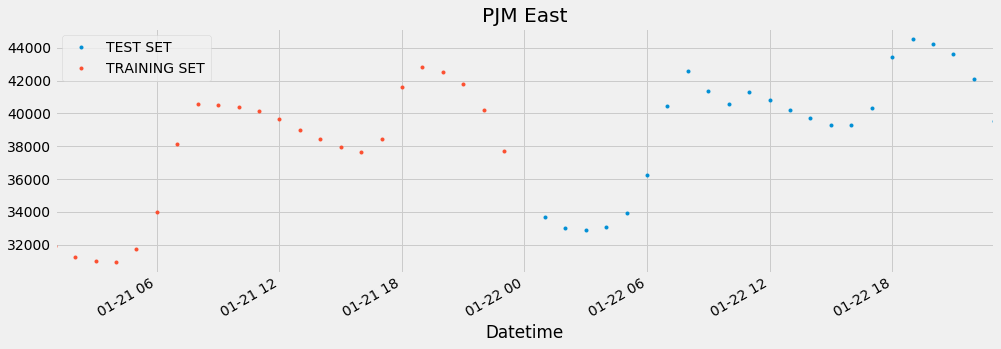

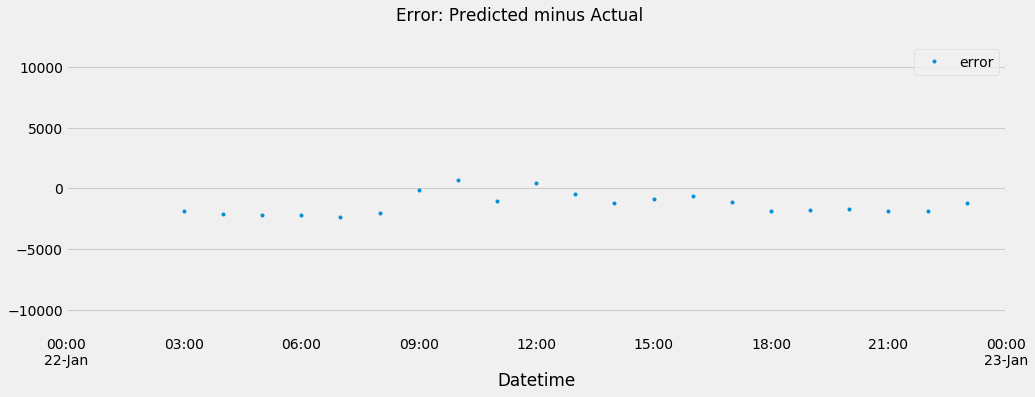

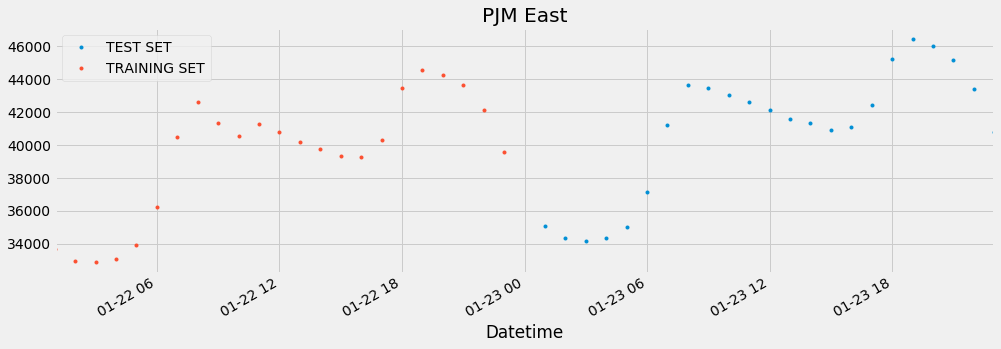

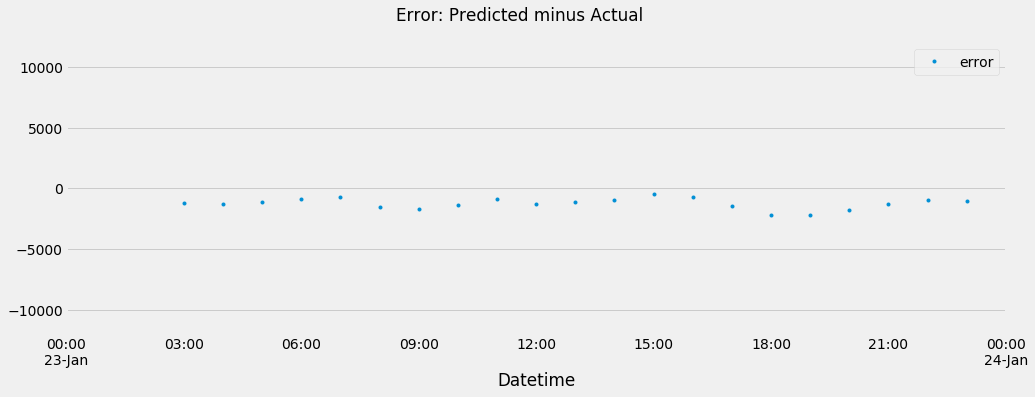

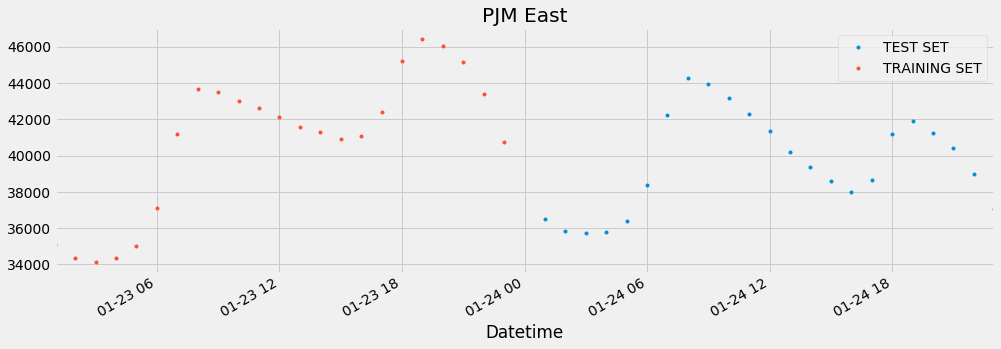

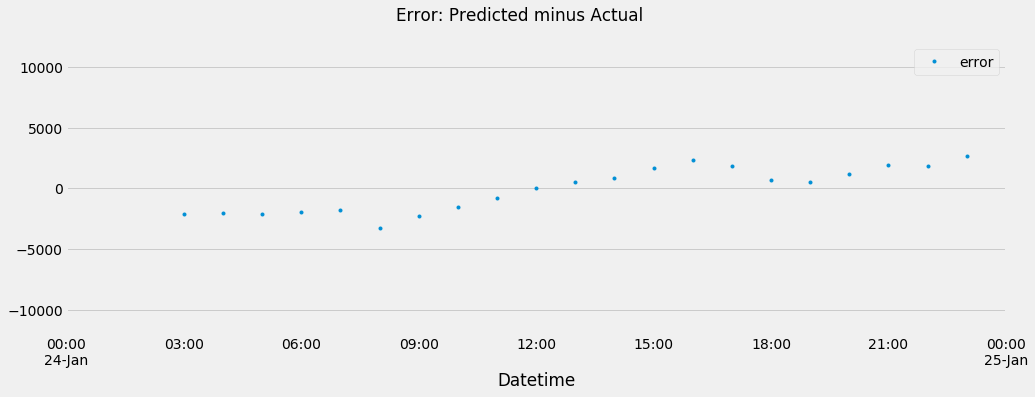

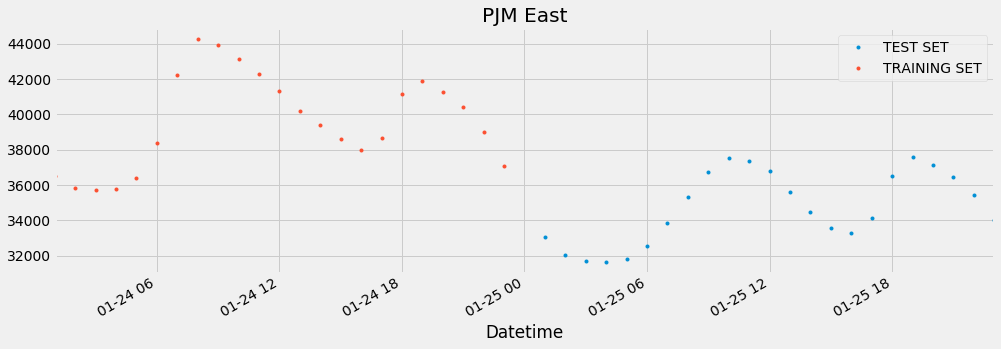

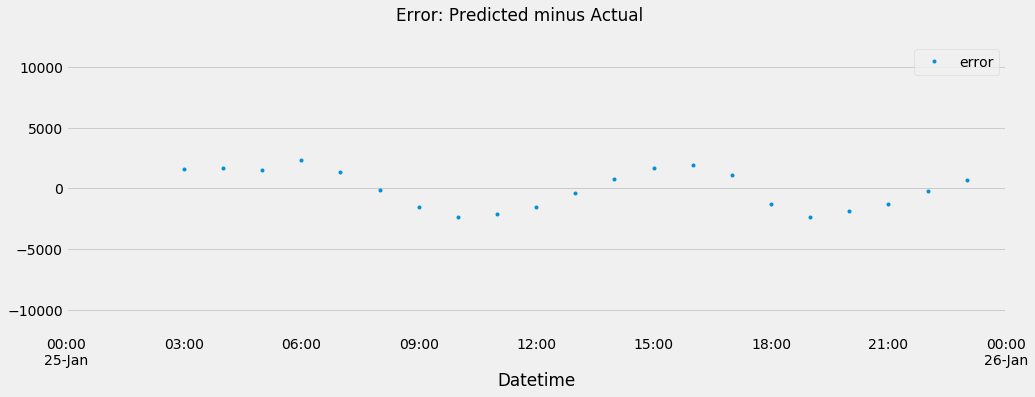

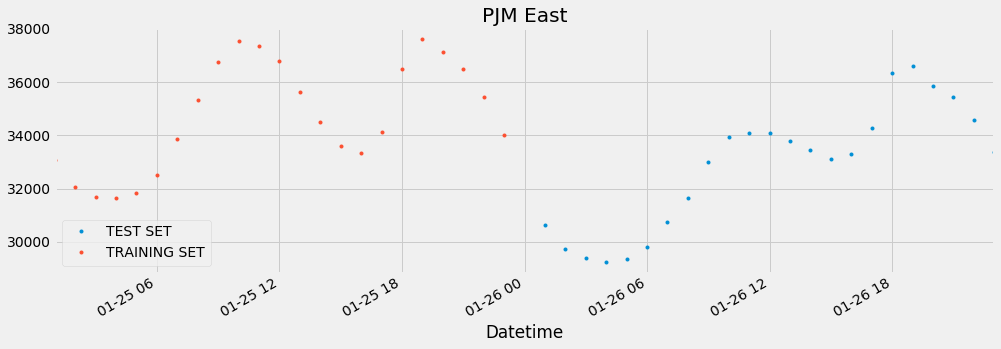

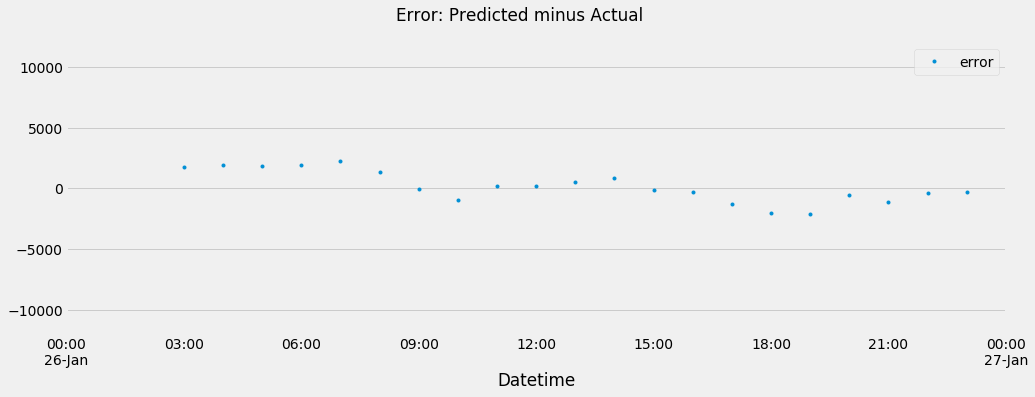

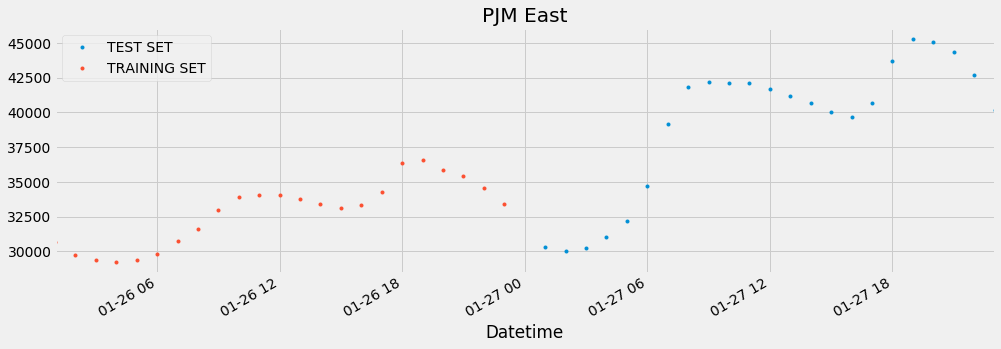

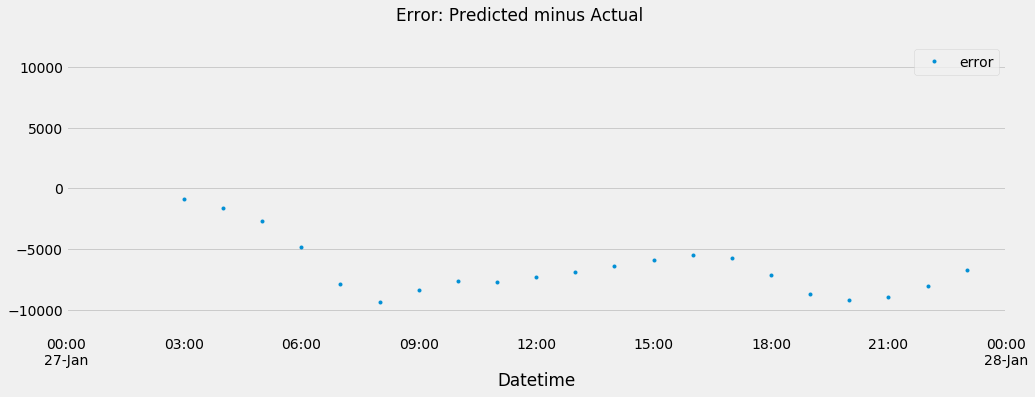

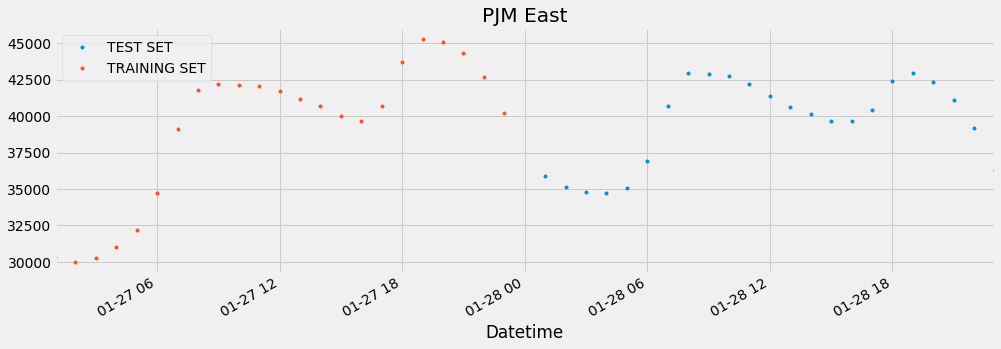

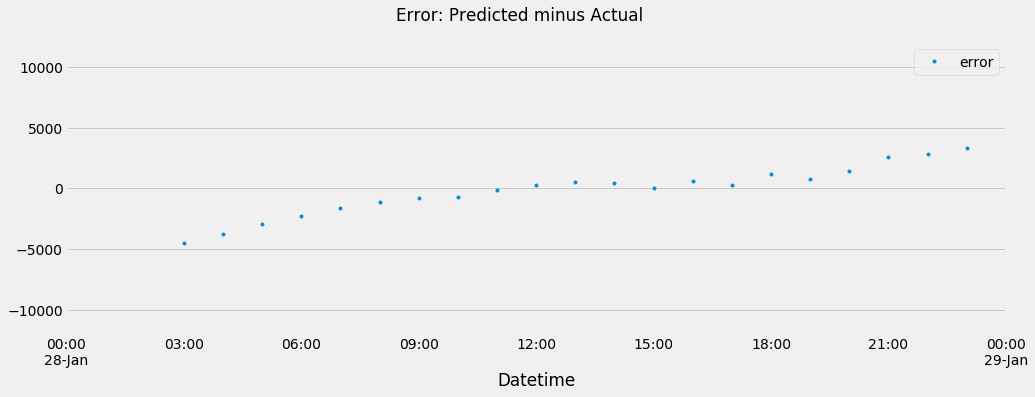

In [28]:
rmse_list, mape_list, dw_list = one_month_daily_predictions('2003', pjme, 2)

### Print Summary Stats for one month of predictions

In [30]:
def print_summary_stats(rmse_list, mape_list, dw_list):
    
    lists = [rmse_list, mape_list, dw_list]
    stats = ['rmse', 'mape', 'dw']
    for i in range(0,len(lists)):
        print(stats[i])
        print("# Days: ", len(lists[i]))
        print("Mean: ", np.mean(lists[i]))
        print("Max: ", np.max(lists[i]))
        print("Min: ", np.min(lists[i]))
        print("SD: ", np.std(lists[i]), '\n')

In [31]:
print_summary_stats(rmse_list, mape_list, dw_list)

rmse
# Days:  27
Mean:  1795.9968755236332
Max:  6940.597607036726
Min:  604.0256770921732
SD:  1385.5053869951992 

mape
# Days:  27
Mean:  4.329077777777778
Max:  15.8862
Min:  1.2036
SD:  3.3579278442089224 

dw
# Days:  27
Mean:  0.3907127476594093
Max:  1.014227721854628
Min:  0.027176692252574304
SD:  0.3108132775247044 



### Predictions and Summary Stats for the Full Year

In [34]:
def full_year_daily_predictions(year, pjme, lag_count):
    """
    Given a specific year, use each day(t) to predict energy usage on day(t+1).
    Note: Only performs calculations on the first 28 days of each month.
    Note: Because this function is plotting each day's resiuduals, this function will break after the first month.
    """
    
    dw_list = []
    rmse_list = []
    mape_list = []

    for month in range(1,13):
        # monthly loop
        for day in range(1,28):
            # day loop
            t_start = '{}-{}-{} 01:00:00'.format(year, month, day)
            t_end = '{}-{}-{} 23:00:00'.format(year, month, day)
            t_plus_one_start = '{}-{}-{} 01:00:00'.format(year, month, day+1)
            t_plus_one_end = '{}-{}-{} 23:00:00'.format(year, month, day+1)
            # get day(t) and day(t+1)
            day_t = pjme[t_start : t_end]
            day_t_plus_one = pjme[t_plus_one_start : t_plus_one_end]
            
            # create X and Y train and test sets
            X_train, y_train = create_features(day_t, lag_count, label='PJME_MW')
            X_test, y_test = create_features(day_t_plus_one, lag_count, label='PJME_MW')
            
            # create model
            reg = create_model(X_train, y_train, X_test, y_test)
            # apply lag to test
            day_t_plus_one = day_t_plus_one[lag_count:]
            # predict
            day_t_plus_one['MW_Prediction'] = reg.predict(X_test)
            # generate error
            day_t_plus_one['error'] = day_t_plus_one['MW_Prediction'] - day_t_plus_one['PJME_MW']
            
            # calculate summary stats
            rmse = math.sqrt(mean_squared_error(y_true=day_t_plus_one['PJME_MW'], y_pred=day_t_plus_one['MW_Prediction']))
            mape = round(mean_absolute_percentage_error(day_t_plus_one['PJME_MW'], day_t_plus_one['MW_Prediction']), 4)
            dw = durbin_watson(day_t_plus_one['error'])
            
            # append stats to list
            rmse_list.append(rmse)
            mape_list.append(mape)
            dw_list.append(dw)
            
    return rmse_list, mape_list, dw_list

In [36]:
rmse_list, mape_list, dw_list = full_year_daily_predictions('2003', pjme, 2)

[09:48:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.050485
[09:48:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.020220
[09:48:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.010107
[09:48:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.028284
[09:48:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total ru

[09:48:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.010116
[09:48:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.030324
[09:48:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.018310
[09:48:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.030459
[09:48:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total ru

[09:49:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.020394
[09:49:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.012326
[09:49:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.018275
[09:49:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.030626
[09:49:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total ru

[09:49:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.020398
[09:49:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.040844
[09:49:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.012265
[09:49:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.010173
[09:49:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total ru

[09:50:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.010232
[09:50:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.010227
[09:50:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.012265
[09:50:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.010170
[09:50:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total ru

[09:50:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.028564
[09:50:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.081700
[09:50:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.022522
[09:50:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.010196
[09:50:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total ru

[09:51:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.020372
[09:51:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.018142
[09:51:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.010188
[09:51:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.030633
[09:51:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total ru

[09:51:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.012271
[09:51:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.030502
[09:51:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.020415
[09:51:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.010160
[09:51:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total ru

[09:52:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.010205
[09:52:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.040808
[09:52:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.010211
[09:52:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:00.124607


In [38]:
print_summary_stats(rmse_list, mape_list, dw_list)

rmse
# Days:  324
Mean:  1741.6993614829535
Max:  9472.361888647505
Min:  301.1398862763467
SD:  1439.590525128503 

mape
# Days:  324
Mean:  4.587007098765432
Max:  23.2206
Min:  0.8463
SD:  3.783628239099194 

dw
# Days:  324
Mean:  0.37227058975535987
Max:  1.9201574142101245
Min:  0.007902762430852014
SD:  0.3159205487695847 



## Conclusion

Even at the daily level, the algorithm seems to have predictive power. This may be due to the nature of the underlying data, however, which seems to be extremely markovian.

#### RMSE
* Average: 1741.70
* Maximum: 9472.36
* Minimum: 301.19
* Std Dev: 1439.59

#### Mean Absolute Percentage Error
* Average: 4.5870
* Maximum: 23.2206
* Minimum: 0.8463%
* Std Dev: 3.7836%

#### Durbin Watson
* Average: 0.3722
* Maximum: 1.9201
* Minimum: 0.0079
* Std Dev: 0.3159


The average Durbin Watson statistic suggests extremely high autocorrelation. This suggests that these single-day models are not generalizable and are likely overfitting the underlying data. Despite that, the algorithm performed fairly well (4.58% MAPE, with a 3.78% standard deviation), outperforming a model trained on 13 years of data without time lags (8.9494% MAPE), demonstrating the impact of including lagged variables.

This suggests that XGBoost can identify temporal dependencies with even only a day's worth of observations, given that the underlying dataset is markovian enough.